In [81]:
# Some useful imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ncx2

In [82]:
class CIR:
    def __init__(self, a, b, sigma, alpha):
        self.a = a
        self.b = b
        self.sigma = sigma
        self.alpha = alpha
        self.b_star = self.b + self.sigma * self.alpha
        self.gamma_star = np.sqrt(self.b_star**2 + 2*self.sigma**2)

    def generate(self, r0, T, N, n):
        r = np.zeros((n, N))
        r[:, 0] = r0
        dt = T/N
        for i in range(1, N):
            r[:, i] = r[:, i-1] + (self.a - self.b * r[:, i-1]) * dt + self.sigma * np.sqrt(r[:, i-1]) * np.sqrt(dt) * np.random.randn(n)
        return r

In [94]:
a = 0.1
b = 0.05
sigma = 0.25
alpha = 0.2
r0 = 0.03     
T = 4       
N = int(252 * T)
n = 5

In [95]:
model = CIR(a, b, sigma, alpha)
trajectories = model.generate(r0, T, N, n)

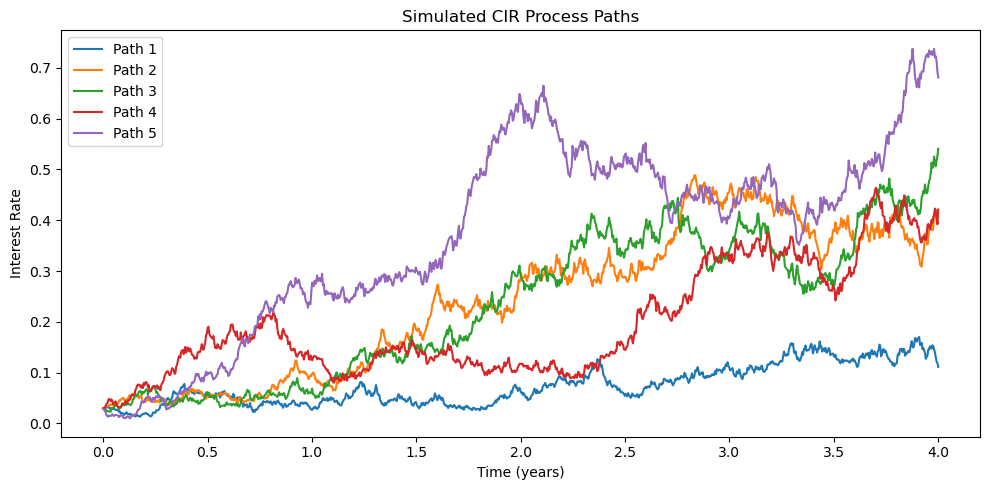

In [96]:
# Plotting
plt.figure(figsize=(10, 5))
for i in range(n):
    plt.plot(np.linspace(0, T, N), trajectories[i], label=f"Path {i+1}")
plt.title("Simulated CIR Process Paths")
plt.xlabel("Time (years)")
plt.ylabel("Interest Rate")
plt.legend()
plt.tight_layout()
plt.show()

# Pricing d'une obligation ZC d'échéance $T$

In [97]:
def phi(t, b_star, gamma_star, sigma):
    num = 2 * gamma_star * np.exp(t*(gamma_star+b_star)/2)
    den = gamma_star - b_star + np.exp(gamma_star*t) * (gamma_star + b_star)
    res = np.log(num/den)
    res = (-2/(sigma**2)) * res
    return res

def psi(t, b_star, gamma_star):
    num = 2*(np.exp(gamma_star*t) - 1)
    den = gamma_star - b_star + np.exp(gamma_star*t) * (gamma_star + b_star)
    return num / den

In [98]:
def P(r, T, N, a, b_star, gamma_star, sigma):
    p = np.zeros(N)
    for i in range(N):
        t = i * T / N
        p[i] = np.exp(-a * phi(T-t, b_star, gamma_star, sigma) - r[i] * psi(T-t, b_star, gamma_star))
    return p

In [99]:
n = 1
model = CIR(a, b, sigma, alpha)
trajectory = model.generate(r0, T, N, n)[0]

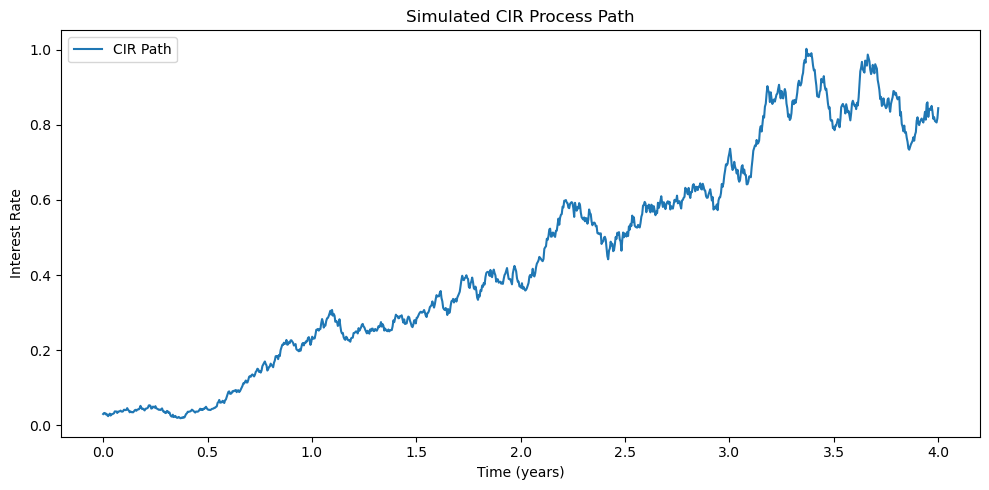

In [100]:
time_grid = np.linspace(0, T, N) 

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(time_grid, trajectory, label='CIR Path')
plt.title("Simulated CIR Process Path")
plt.xlabel("Time (years)")
plt.ylabel("Interest Rate")
plt.legend()
plt.tight_layout()
plt.show()

In [101]:
prices = P(trajectory, T, N, a, model.b_star, model.gamma_star, sigma)

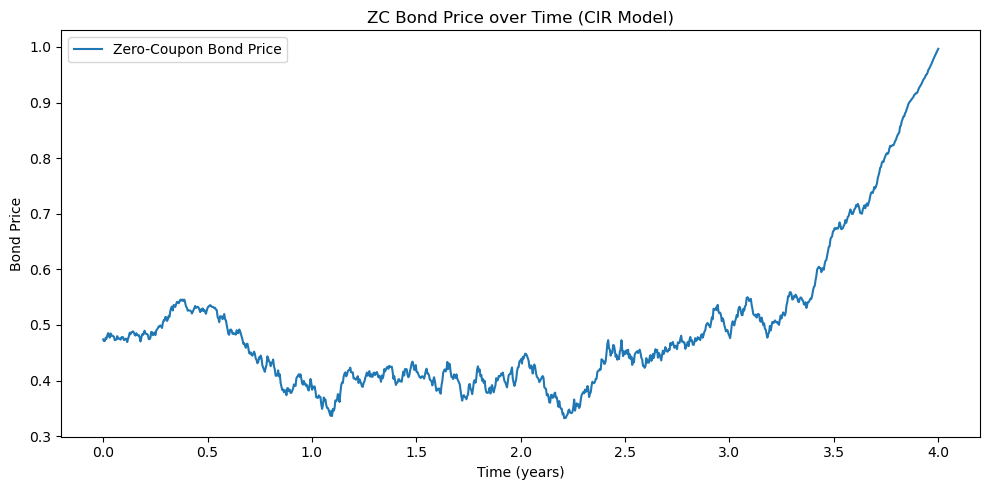

In [102]:
# === Display result ===
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, T, N), prices, label='Zero-Coupon Bond Price')
plt.title("ZC Bond Price over Time (CIR Model)")
plt.xlabel("Time (years)")
plt.ylabel("Bond Price")
plt.legend()
plt.tight_layout()
plt.show()

# Prix d'un call européen d'échéance $\theta$ et de prix d'exercice K sur une obligation ZC d'échéance $T$

In [103]:
def zeta_1(r0, b_star, gamma_star, sigma, theta):
    num = 8*r0 * gamma_star**2 * np.exp(gamma_star*theta)
    den = sigma**2 * (np.exp(gamma_star*theta)-1) * (gamma_star * (np.exp(gamma_star*theta) + 1) + b_star) * (np.exp(gamma_star * theta) - 1)
    return num / den

def zeta_2(r0, b_star, gamma_star, sigma, theta, T):
    num = 8*r0 * gamma_star**2 * np.exp(gamma_star*theta)
    den = sigma**2 * (np.exp(gamma_star*theta) - 1)
    den = den * (gamma_star * (np.exp(gamma_star * theta)+1) + (sigma**2 * psi(T-theta, b_star, gamma_star) + b_star)*(np.exp(gamma_star*theta)-1)) 
    return num / den

def r_star(a, b_star, gamma_star, theta, T, K):
    num = a*phi(T-theta, b_star, gamma_star, sigma) + np.log(K)
    den = psi(T-theta, b_star, gamma_star)
    return -num / den

def L_1(b_star, gamma_star, sigma, theta):
    num = np.exp(gamma_star*theta)-1
    den = gamma_star*(np.exp(gamma_star*theta)+1) + b_star*(np.exp(gamma_star*theta)-1)
    return (sigma**2/2)*(num/den)

def L_2(b_star, gamma_star, sigma, theta, T):
    num = np.exp(gamma_star*theta)-1
    den = gamma_star*(np.exp(gamma_star*theta)+1)
    den += (sigma**2*psi(T-theta, b_star, gamma_star) + b_star) * (np.exp(gamma_star*theta)-1)
    return (sigma**2/2) * (num/den)

def C0(r0, r, a, b_star, gamma_star, sigma, theta, T, N, K):
    r_s = r_star(a, b_star, gamma_star, theta, T, K)
    f1 = ncx2.cdf(r_s/L_2(b_star, gamma_star, sigma, theta, T), df=4*a/(sigma**2), nc=zeta_2(r0, b_star, gamma_star, sigma, theta, T))
    f2 = ncx2.cdf(r_s/L_1(b_star, gamma_star, sigma, theta), df=4*a/(sigma**2), nc=zeta_1(r0, b_star, gamma_star, sigma, theta))

    p1 = P(r, T, N, a, b_star, gamma_star, sigma)
    p2 = P(r, theta, N, a, b_star, gamma_star, sigma)

    return p1[0] * f1 - K * p2[0] * f2

In [105]:
theta = 1
K = 0.5
call_price = C0(r0, trajectory, model.a, model.b_star, model.gamma_star, model.sigma, theta, T, N, K)
print(call_price)

0.11097211098486978
